<a href="https://colab.research.google.com/github/kulkarnisatishp/genai-course/blob/main/Capstone_Project_Multimodal_Data_Starter_File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

In [ ]:
# Install necessary libraries
!pip install -q openai langchain langchain-openai langchain-community openai-whisper sentence-transformers pdf2image
!apt-get install poppler-utils
!pip install --upgrade Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 38.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-util

In [5]:
%cd /content/drive/MyDrive/GenAI/RAG/CAPSTONE PROJECT - MultiModal Starbucks Finance

/content/drive/MyDrive/GenAI/RAG/CAPSTONE PROJECT - MultiModal Starbucks Finance


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from google.colab import userdata
api_key = userdata.get('openai_key')

In [8]:
# Import libraries
from langchain_openai import ChatOpenAI
from openai import OpenAI
from IPython.display import display, Markdown
from sentence_transformers import SentenceTransformer
import whisper
import pandas as pd
import base64
from pdf2image import convert_from_path
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import os
import torch

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Audio Transcription

In [9]:
# Check if the GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [10]:
# Checking which models are available
whisper.available_models()

['tiny.en',
 'tiny',
 'base.en',
 'base',
 'small.en',
 'small',
 'medium.en',
 'medium',
 'large-v1',
 'large-v2',
 'large-v3',
 'large',
 'large-v3-turbo',
 'turbo']

In [11]:
# Transcribe the audio using Whisper
model = whisper.load_model(name = 'large-v3-turbo',
                           device = device)
input_file = "starbucks-q3.mp3"
result = model.transcribe(audio = input_file)

100%|█████████████████████████████████████| 1.51G/1.51G [00:23<00:00, 69.5MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

In [12]:
# Check the transcription output
transcription_text= result['text']
print("Transcription text:")
print(transcription_text)

Transcription text:
 2024. And with that, I'll now tell you the call over to Lakshman. Thank you, Tiffany, and thank you for joining us this afternoon. Let me start by laying out our results for this quarter. Our Q3 total company revenue was $9.1 billion, up 1% year-over-year, and 6% over Q2. Our global comparable store sales declined 3% year-over-year, driven by a negative 2% comp growth in North America and a negative 14% comp growth in China, and partially offset by strong performance in Japan. Our global operating margins contracted by 70 basis points to 16.7%, and overall earnings per share for the quarter was $0.93. Our total company results were in line with guidance, but international performance, particularly in China, was challenged. We are not satisfied with the results, but our actions are making an impact. Leading business and operational indicators are trending in the right direction ahead of our financial results, and our runway for improvement is long. We see green shoo

In [13]:
# Save the transcription to a text file
os.makedirs("transcript", exist_ok = True)
with open("transcript/transcript.txt", "w") as f:
  f.write(transcription_text)

# Embedding the Audio

In [14]:
# Loading the transcription text into chunks of 100 characters
with open("transcript/transcript.txt", "r") as f:
  text = f.read()

chunk_size = 250
audio_chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# Summary of the the chunks
print(f"Number of chunks: {len(audio_chunks)}")
print(f"First chunk: {audio_chunks[3]}")

Number of chunks: 56
First chunk: fied with the results, but our actions are making an impact. Leading business and operational indicators are trending in the right direction ahead of our financial results, and our runway for improvement is long. We see green shoots in our U.S. busin


In [15]:
# Load the Clip model and embed the chunks
clip_model = SentenceTransformer('clip-ViT-B-32', device = device)
audio_embeddings = clip_model.encode(audio_chunks)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

In [16]:
# Check the shape of the embeddings
print(f"Shape of embeddings: {audio_embeddings.shape}")

Shape of embeddings: (56, 512)


# PDF to image transformation

In [17]:
# Defining the paths for the PDf and the images
pdf_path = "3Q24-Earnings-Release.pdf"
output_folder = "images"
os.makedirs(output_folder, exist_ok = True)

In [18]:
# Convert each page of PDF to images
images = convert_from_path(pdf_path)
image_paths = []

for i, image in enumerate(images):
  image_path = os.path.join(output_folder, f"page_{i+1}.jpg")
  image.save(image_path, "JPEG")
  image_paths.append(image_path)

print(f"Number of images/pages is {len(image_paths)}")
print(f"Examples of 3 image paths {image_paths[:3]}")

Number of images/pages is 17
Examples of 3 image paths ['images/page_1.jpg', 'images/page_2.jpg', 'images/page_3.jpg']


# Embedding the images

In [19]:
# Using the clip model to embed images
image_embeddings = []

for filename in os.listdir(output_folder):
  if filename.endswith(".jpg"):
    image_path = os.path.join(output_folder, filename)
    image = Image.open(image_path)
    embedding = clip_model.encode(image)
    image_embeddings.append(embedding)

In [20]:
# Check the image embeddings
print(f"Shape of image embeddings: {len(image_embeddings)}")
print(f"The shape of embeddings is {image_embeddings[0].shape}")

Shape of image embeddings: 17
The shape of embeddings is (512,)


# Retrieval system

In [21]:
# Defining a query
query = "what are the short term risks for the company"
query_embeddings = clip_model.encode(query)

In [22]:
# Compute the similarity with the transcription embeddings
audio_similarities = cosine_similarity([query_embeddings], audio_embeddings)[0]

In [23]:
# Order the top K (20) most similar audios
k = 20
top_k_audio_similarities = audio_similarities.argsort()[-k:][::-1]

In [24]:
# Show the most similar audios and their similariries
print(f"The top 5 most similar chunks are {top_k_audio_similarities[:5]}")
print(f"The corresponding similarities are {audio_similarities[top_k_audio_similarities[:5]]}")

The top 5 most similar chunks are [48 47 50 49 21]
The corresponding similarities are [0.8492435  0.8403225  0.8390345  0.8388392  0.83797294]


In [25]:
# Comput the cosine similarity with the image embeddings
image_similarities = cosine_similarity([query_embeddings], image_embeddings)[0]

In [26]:
# print the top k images in terms of similarities
k = 5
top_k_image_similarities = image_similarities.argsort()[-k:][::-1]

In [27]:
# Display the top 5 images
print(f"The top 5 most similar images are {top_k_image_similarities[:5]}")
print(f"The corresponding similarities are {image_similarities[top_k_image_similarities[:5]]}")

The top 5 most similar images are [11 12  0  3  9]
The corresponding similarities are [0.2644042  0.2597667  0.25643957 0.2551114  0.25334686]


# Prepare the context

In [28]:
# Combine the top k transcriptions
k = 5
text_context = ' '.join([audio_chunks[idx] for idx in top_k_audio_similarities[:k]])

In [29]:
# Retrieve the top k images and transform into base64
base64frame = []
for idx in top_k_image_similarities[:k]:
  image_path = image_paths[idx]
  with open(image_path, "rb") as image_file:
    base64frame.append(base64.b64encode(image_file.read()).decode('utf-8'))
base64frame

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAiYBqQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigA

# Generative System

In [30]:
# Connecting to the openAI API
client = OpenAI(api_key = api_key)

In [31]:
# Define the system prompt
system_prompt = f"""
You are a financial advisor expert in publicly traded companies.
you must answer the {query}
You explain in clear terms with the data available only"""

[{'type': 'image_url',
  'image_url': {'url': '',
   'detail': 'high'}},
 {'type': 'image_url',
  'image_url': {'url': '',
   'detail': 'high'}},
 {'type': 'image_url',
  'image_url': {'url': '',
   'detail': 'high'}},
 {'type': 'image_url',
  'image_url': {'url': '',
   'detail': 'high'}},
 {'type': 'image_url',
  'image_url': {'url': '',
   'detail': 'high'}}]
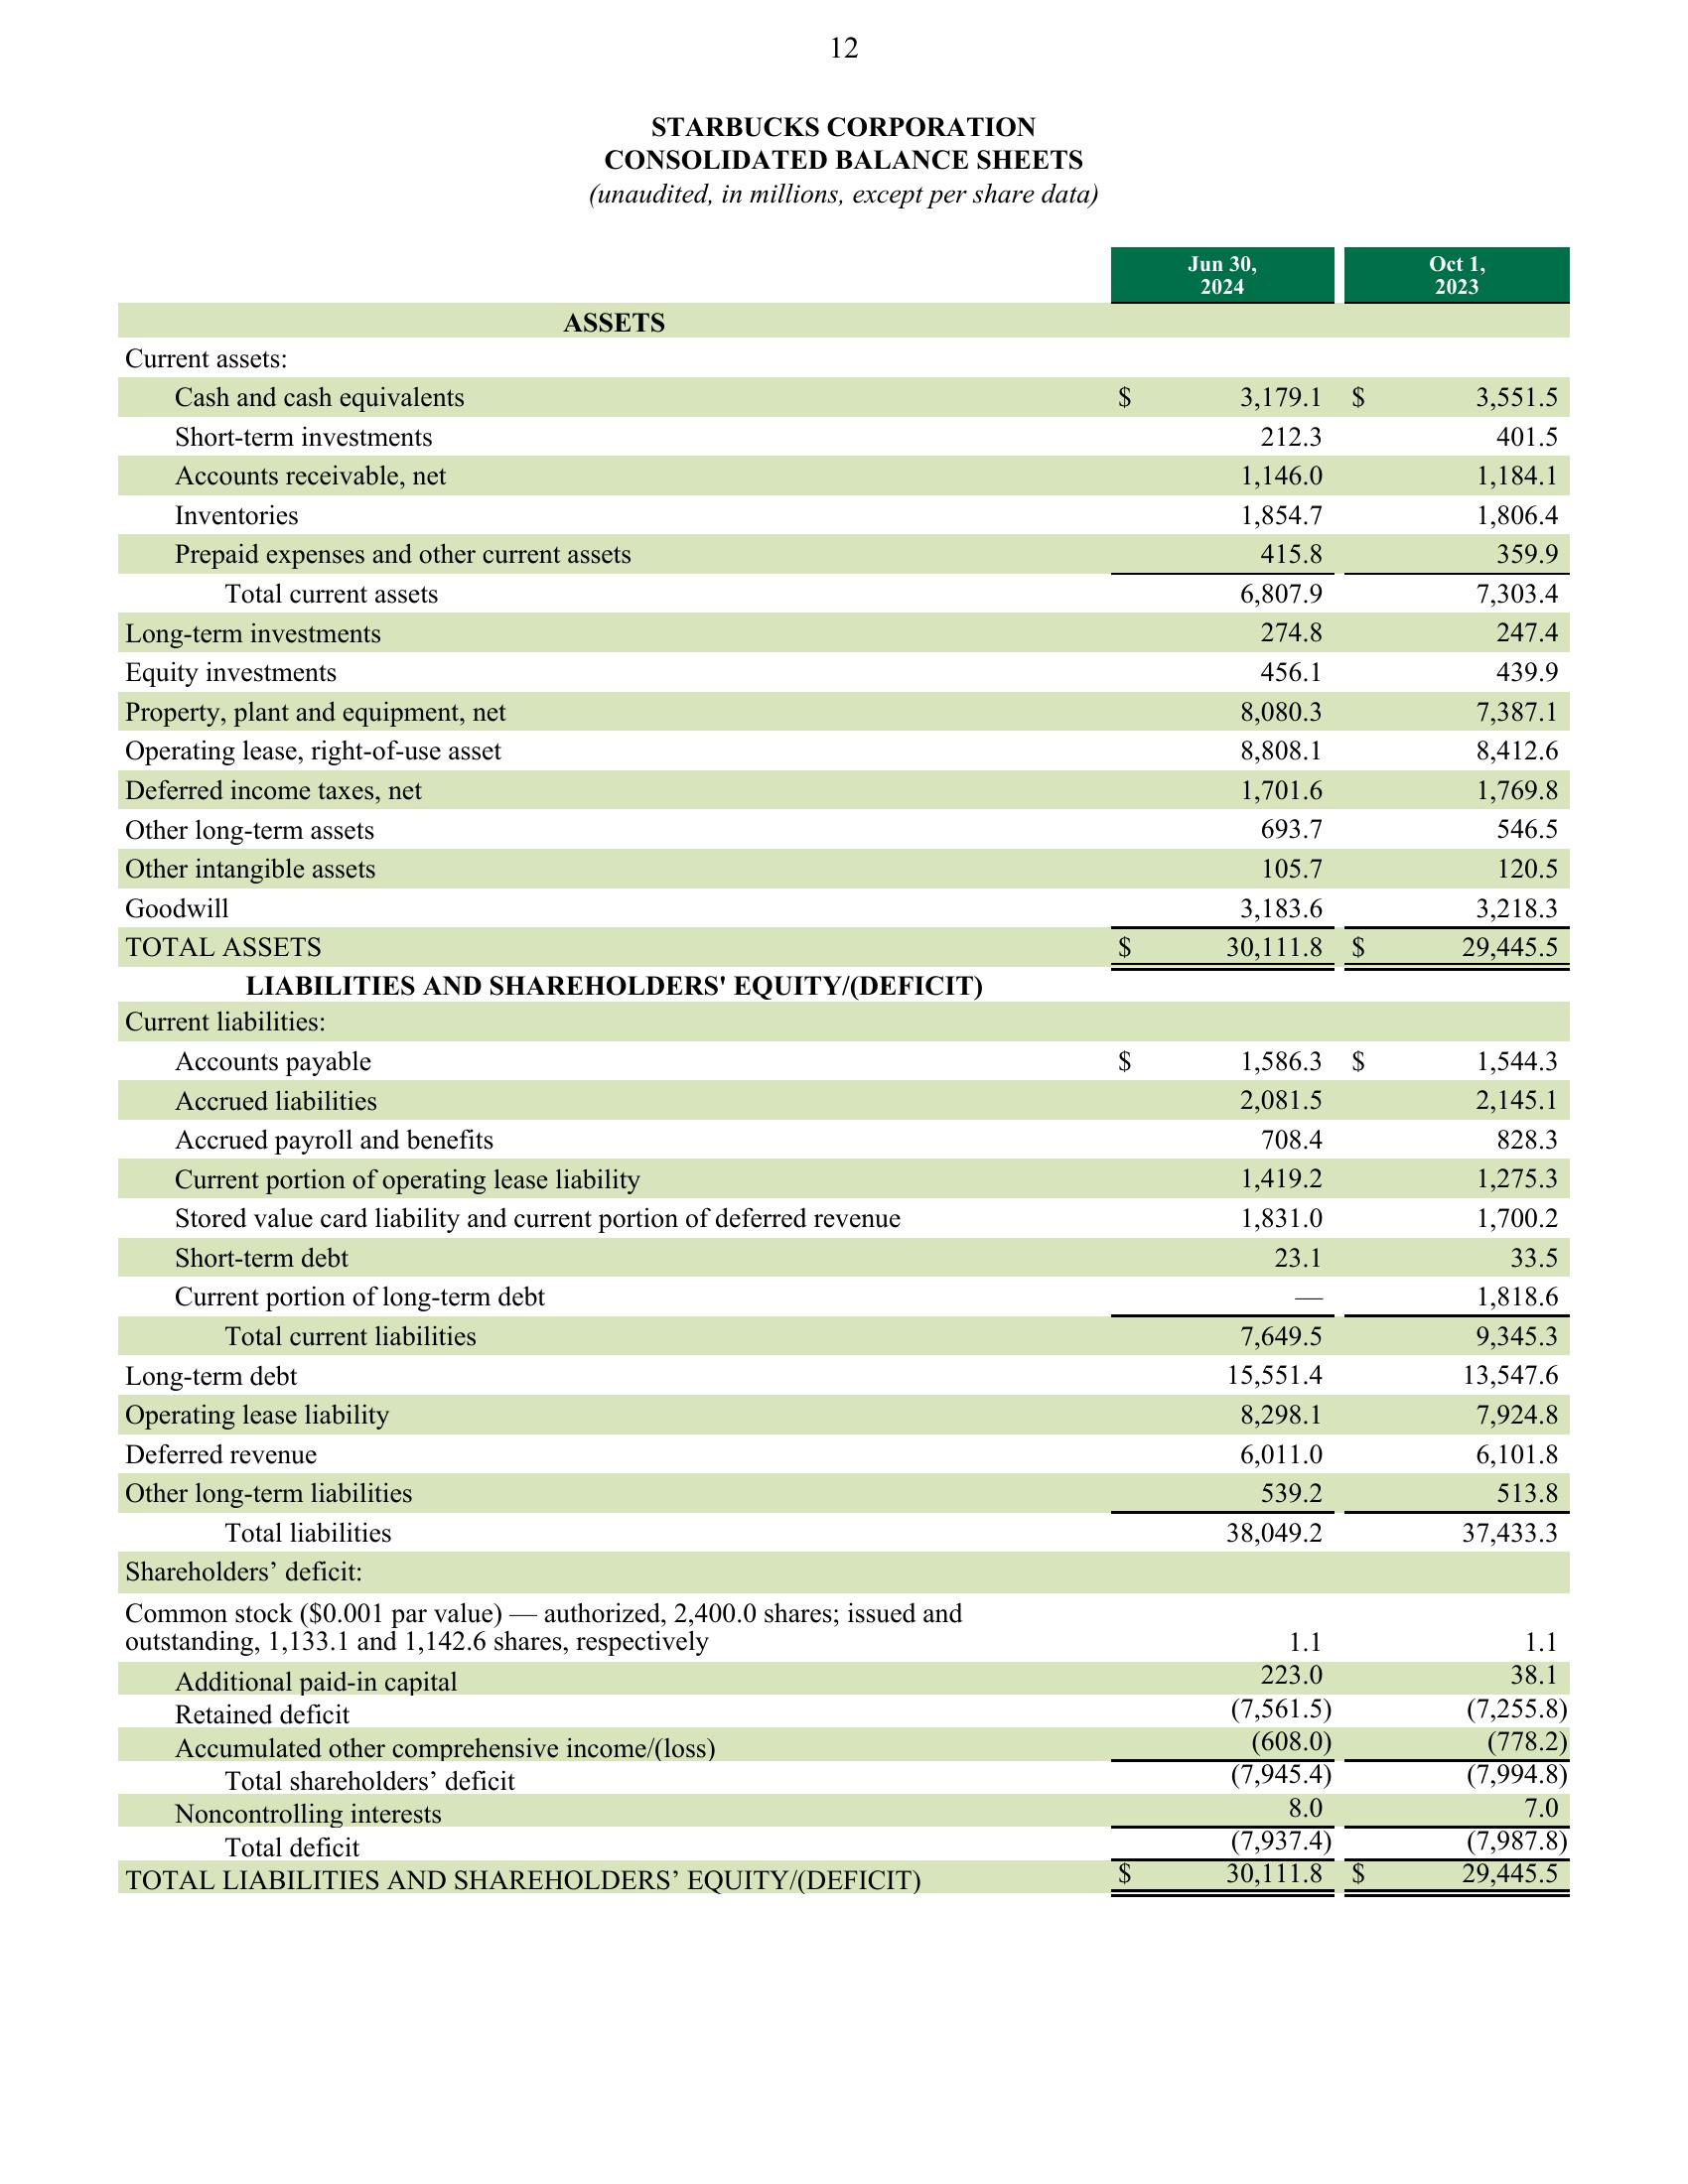
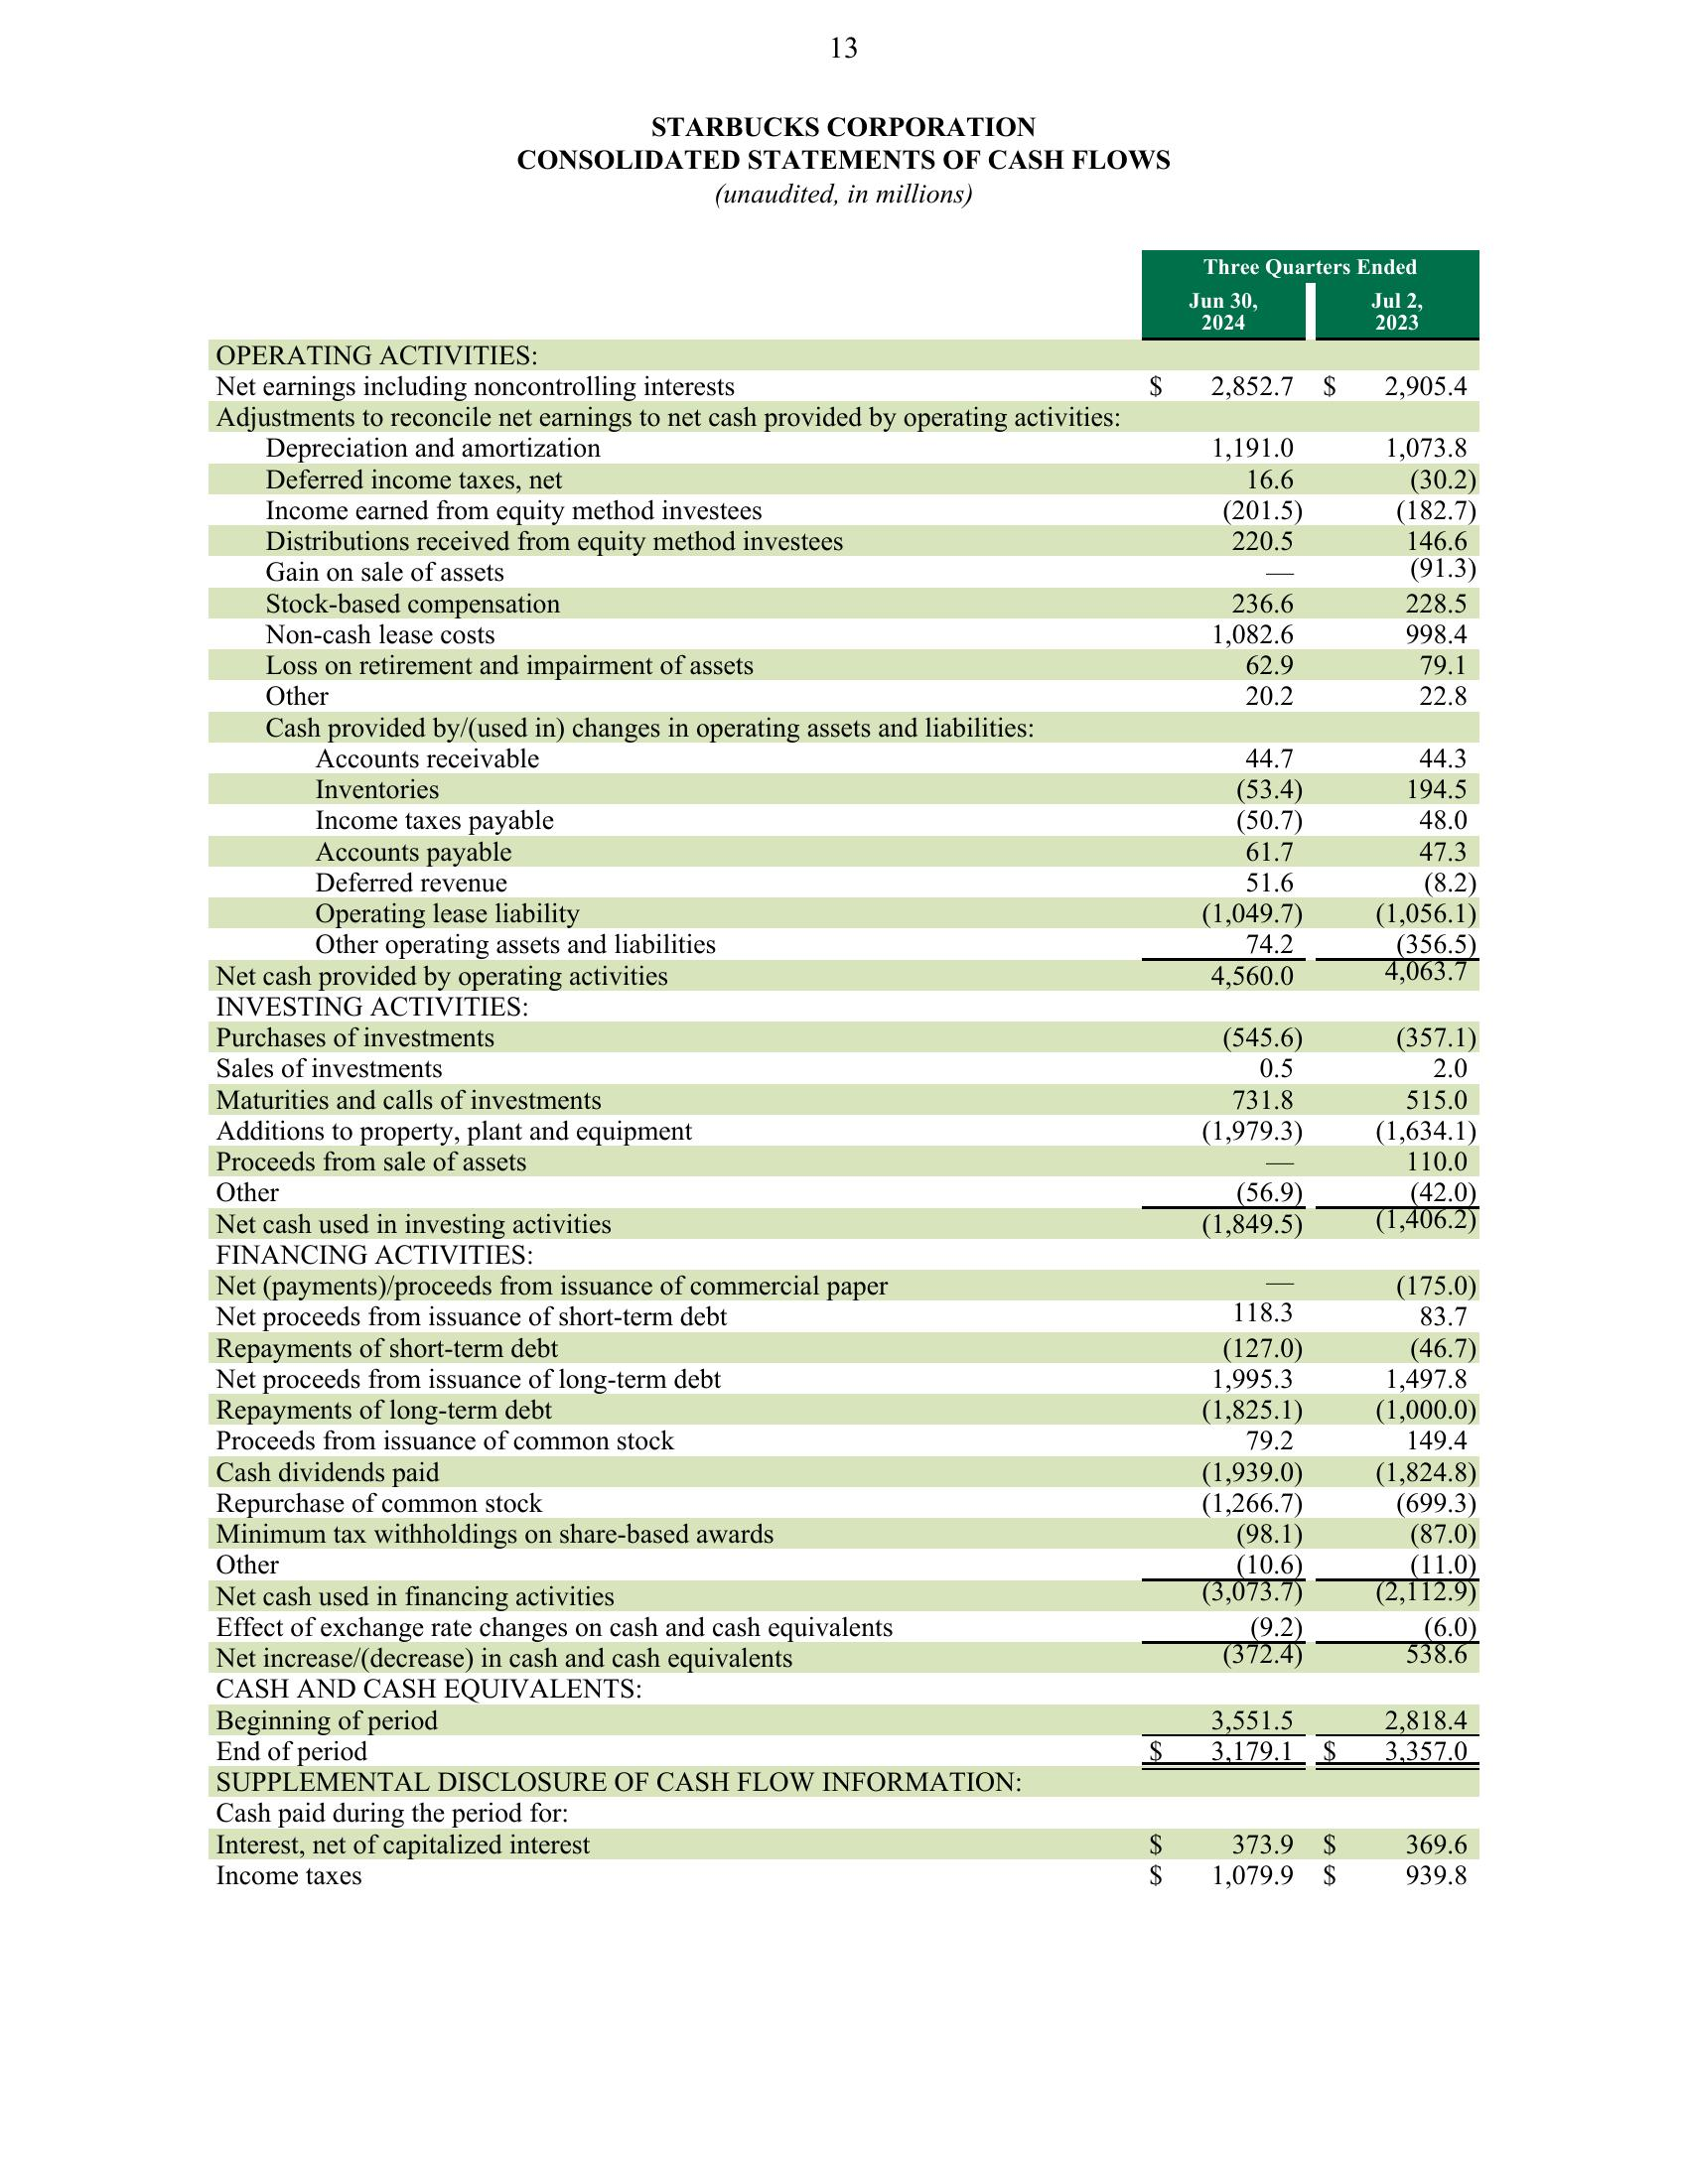
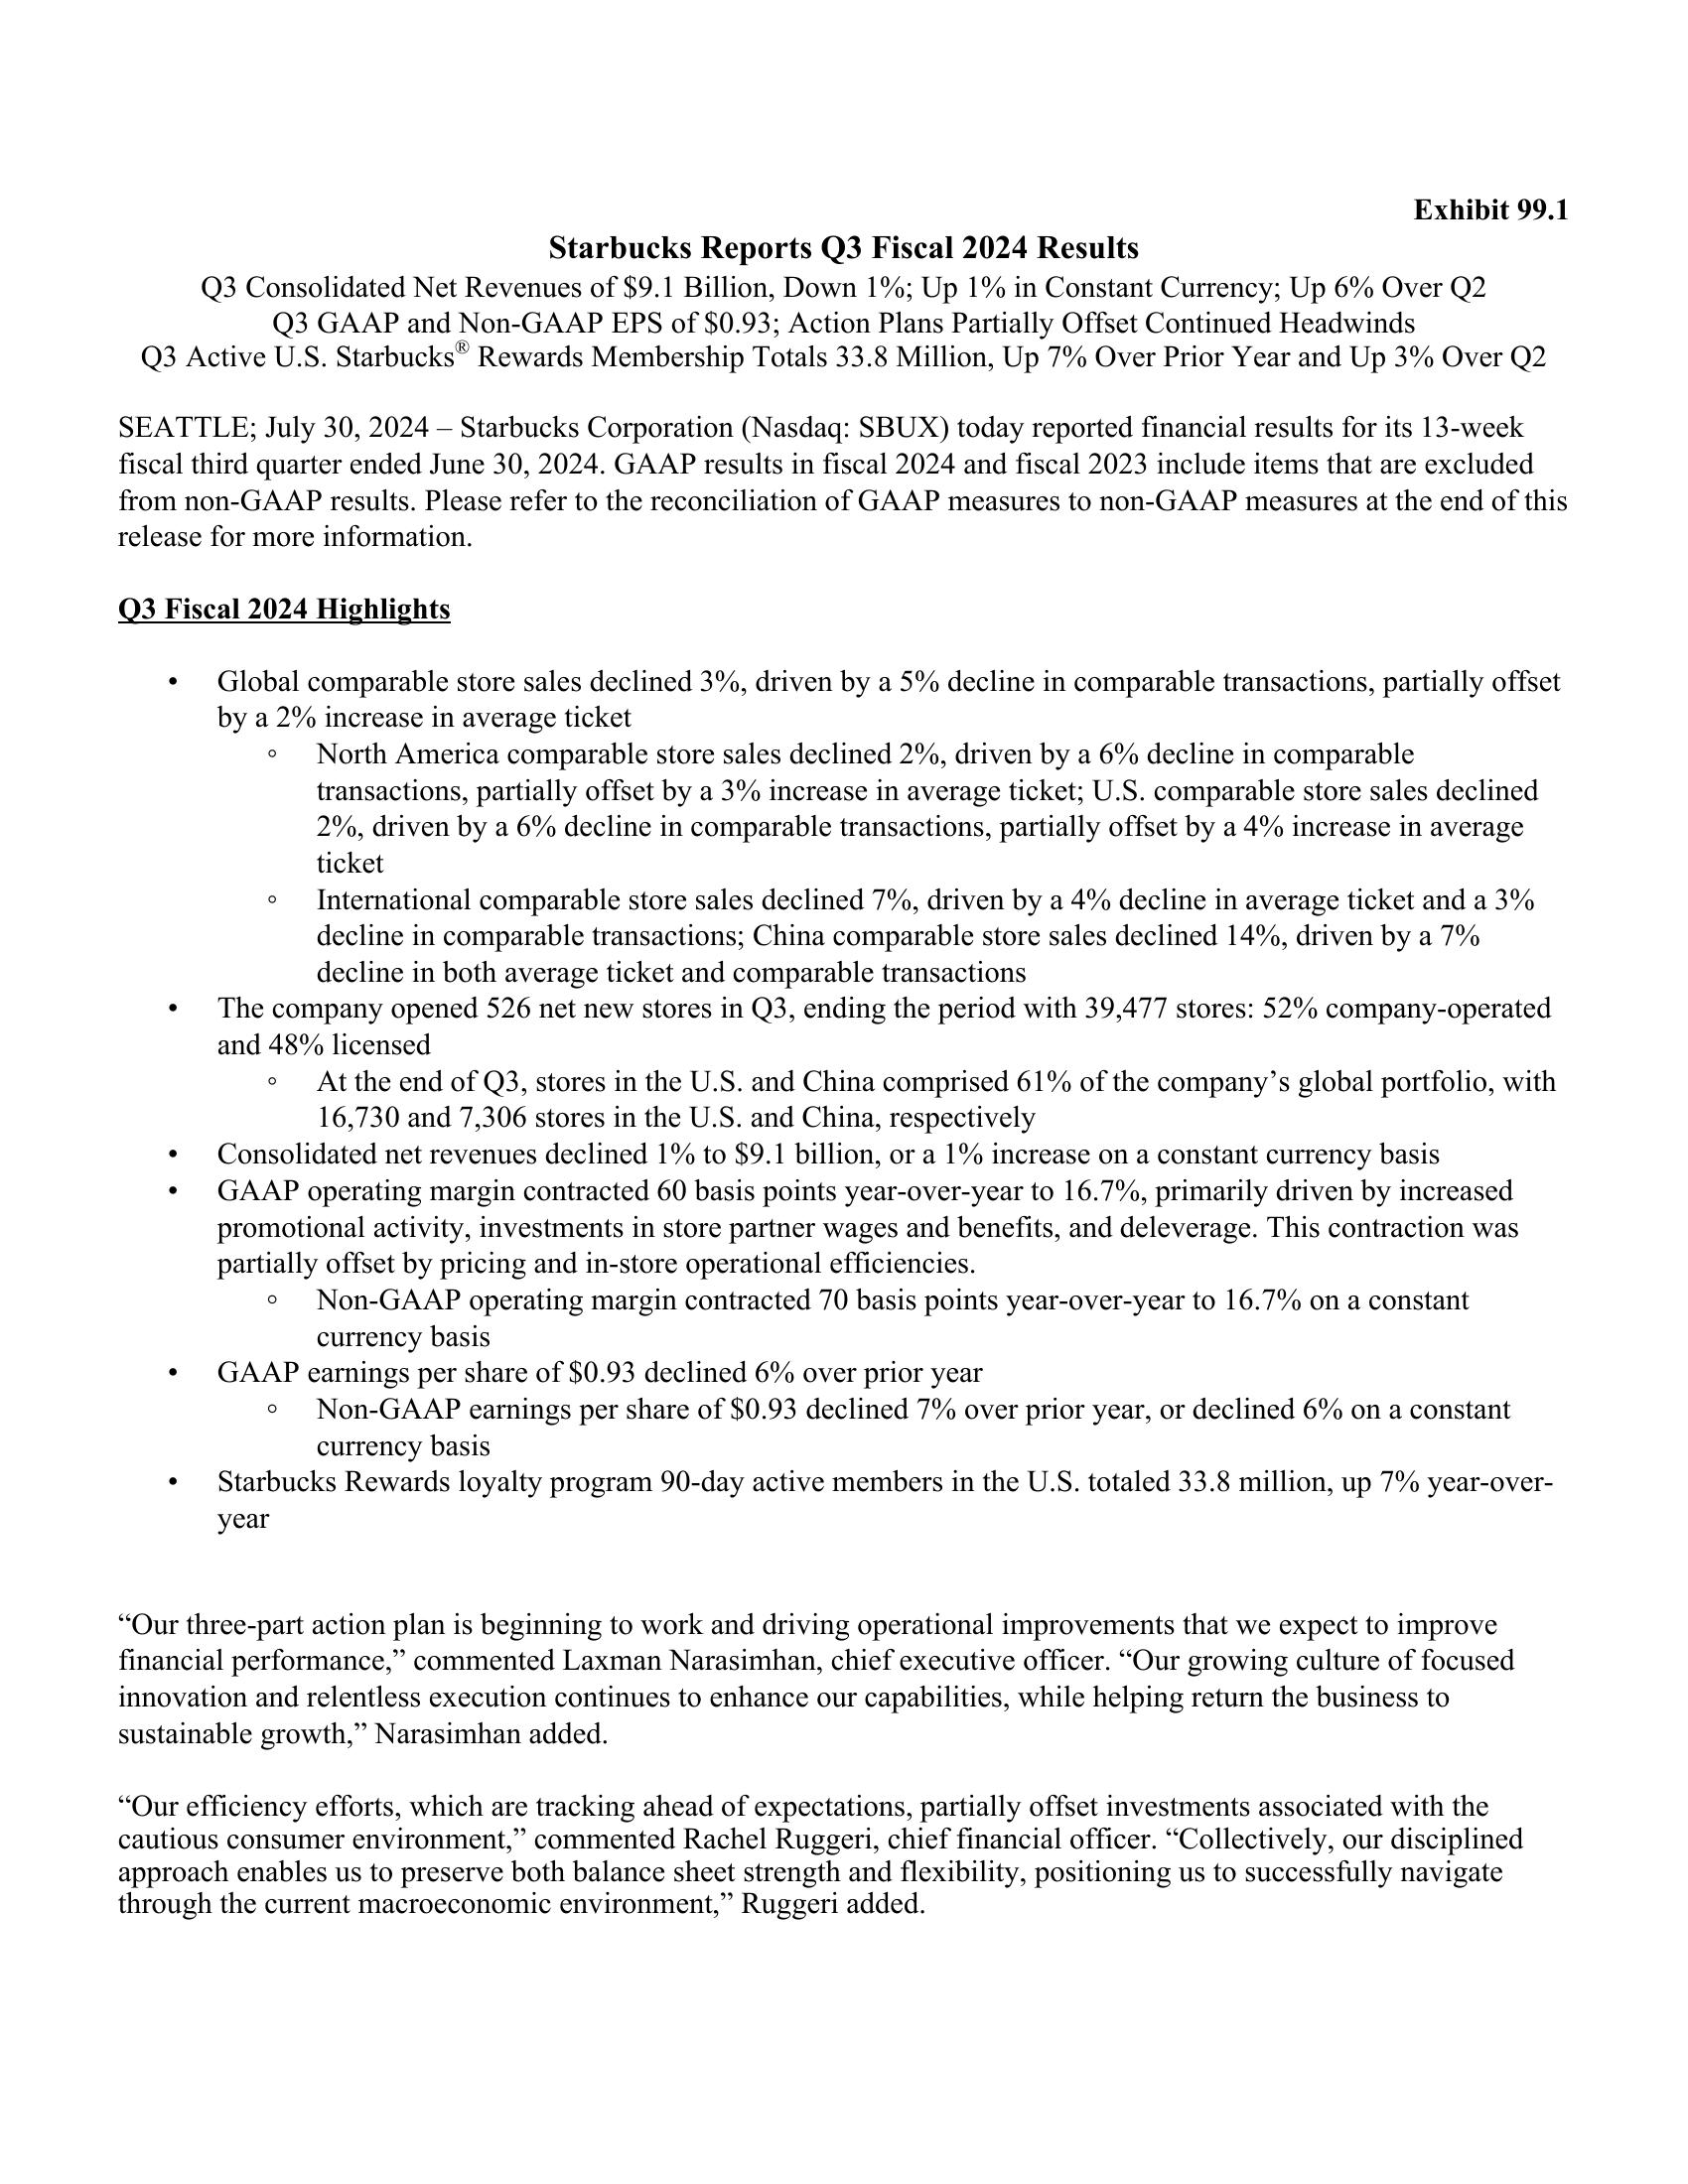
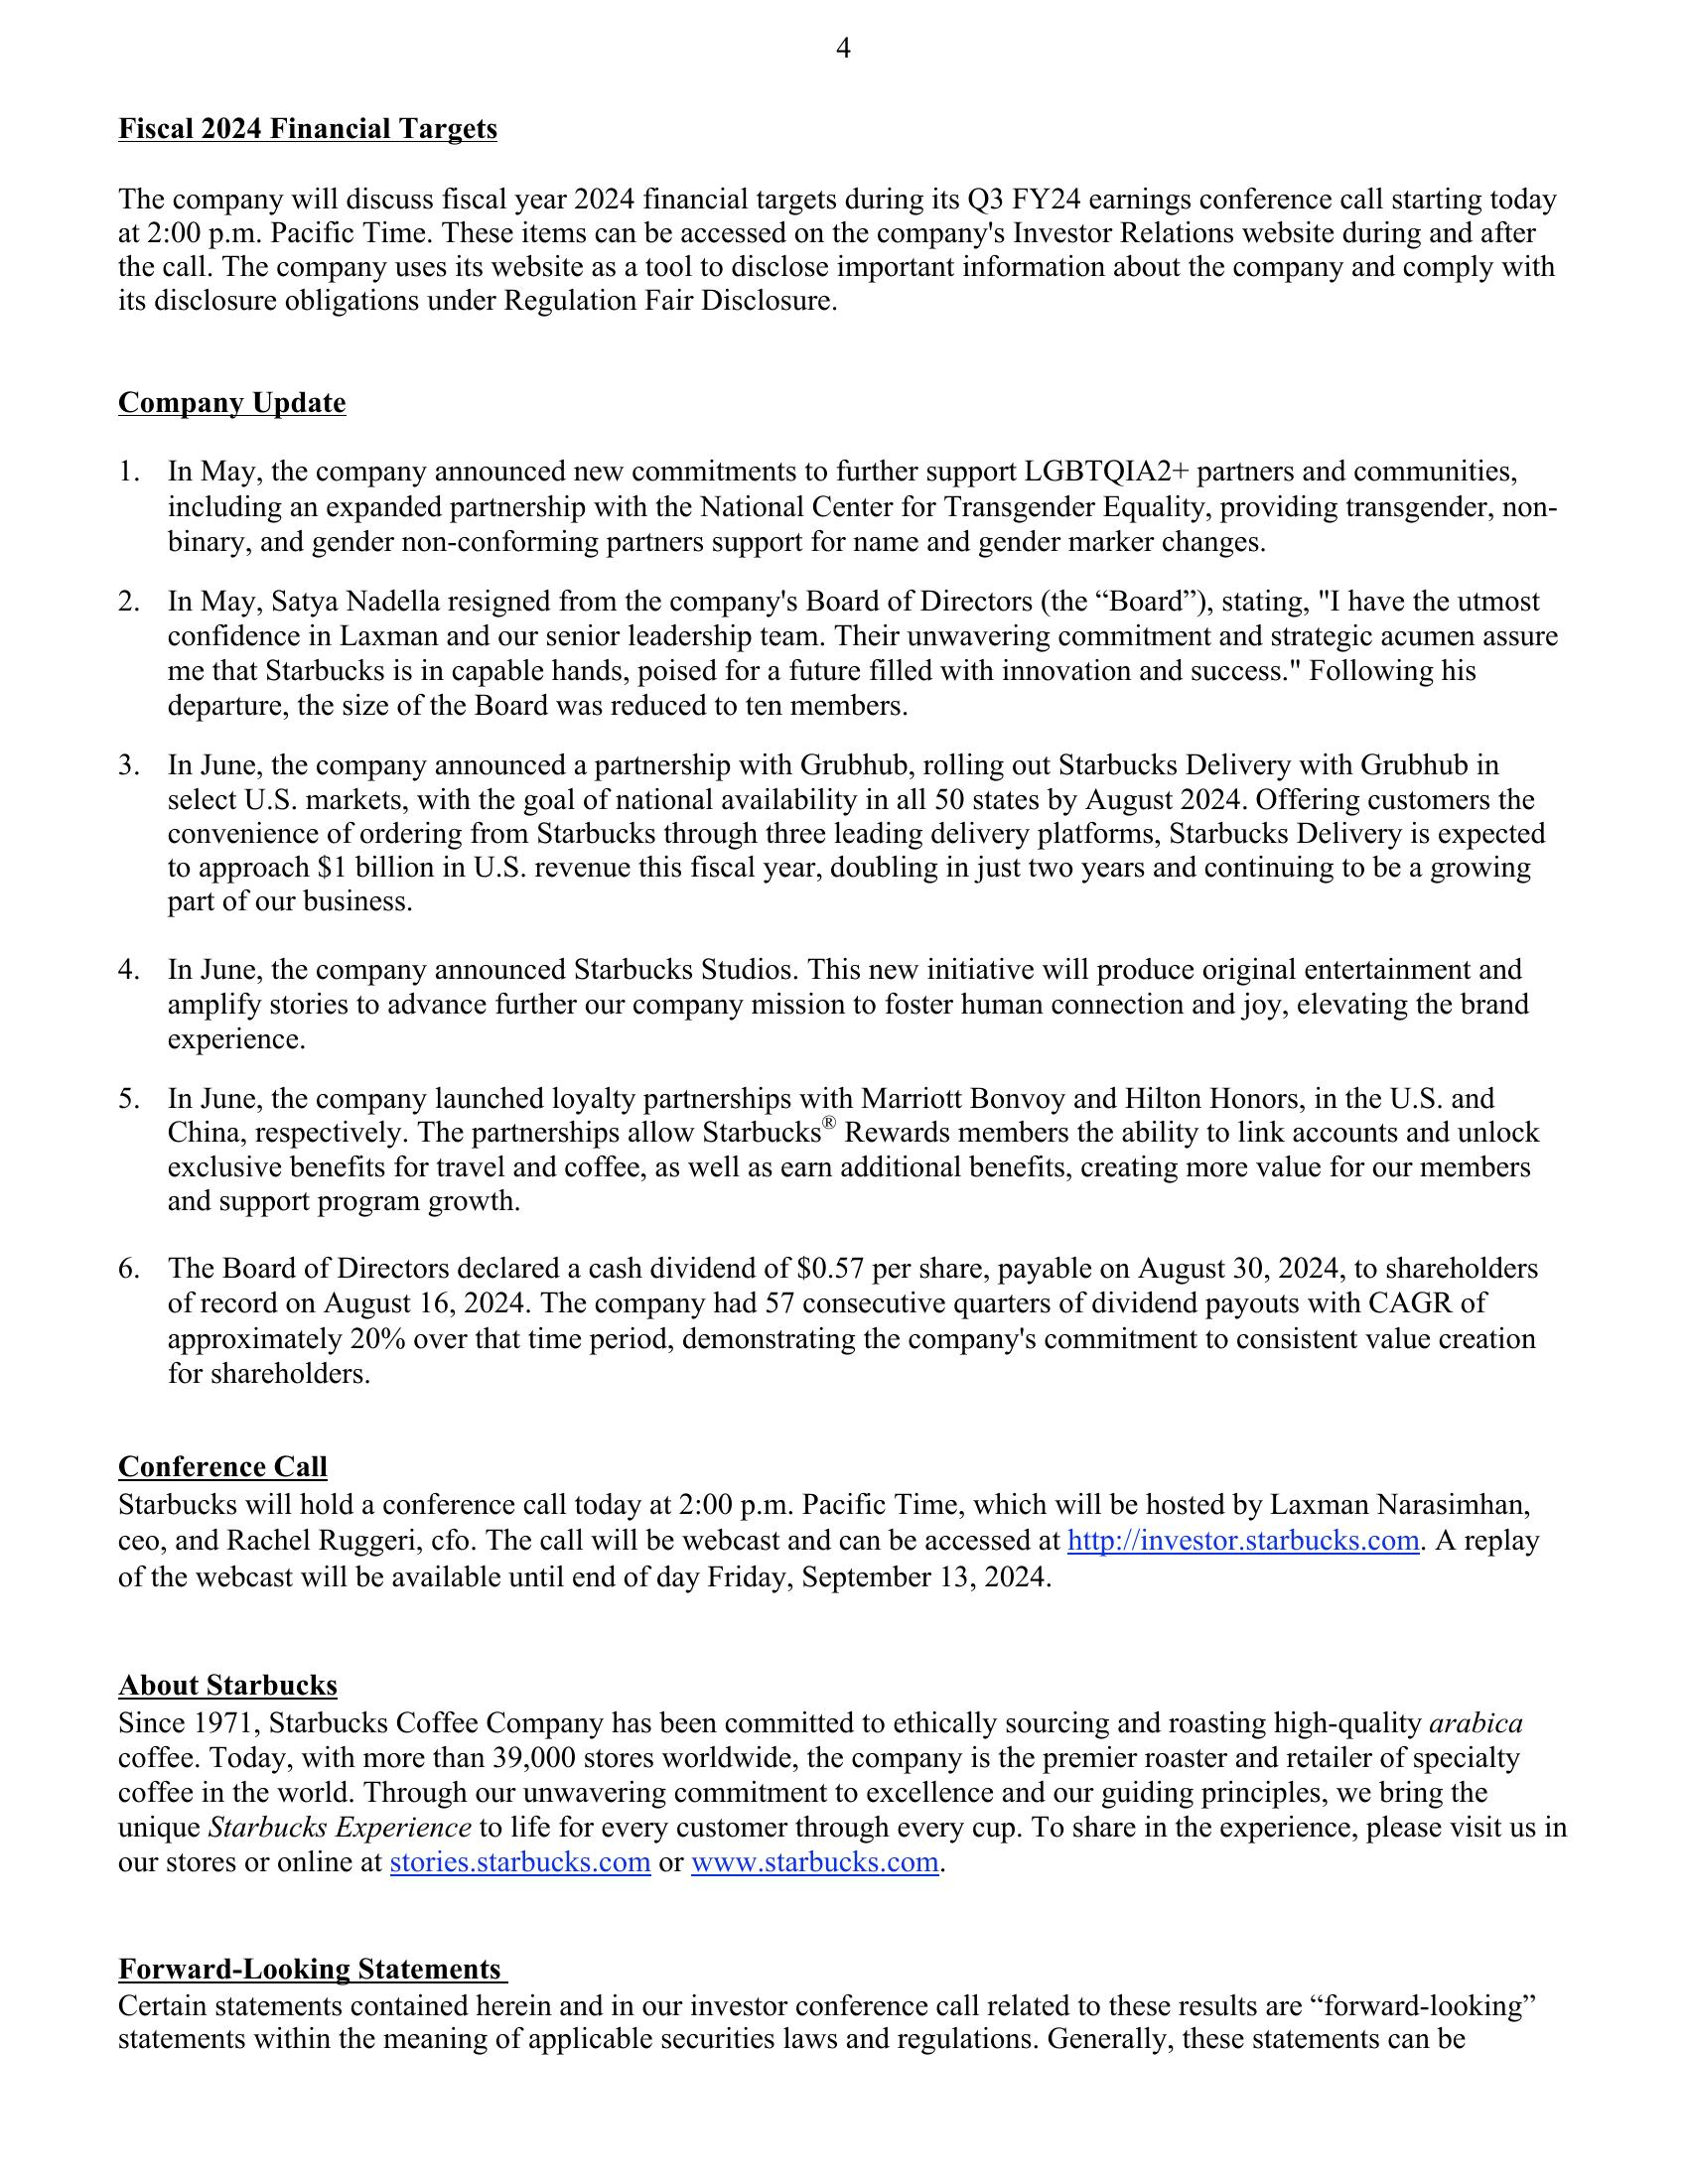
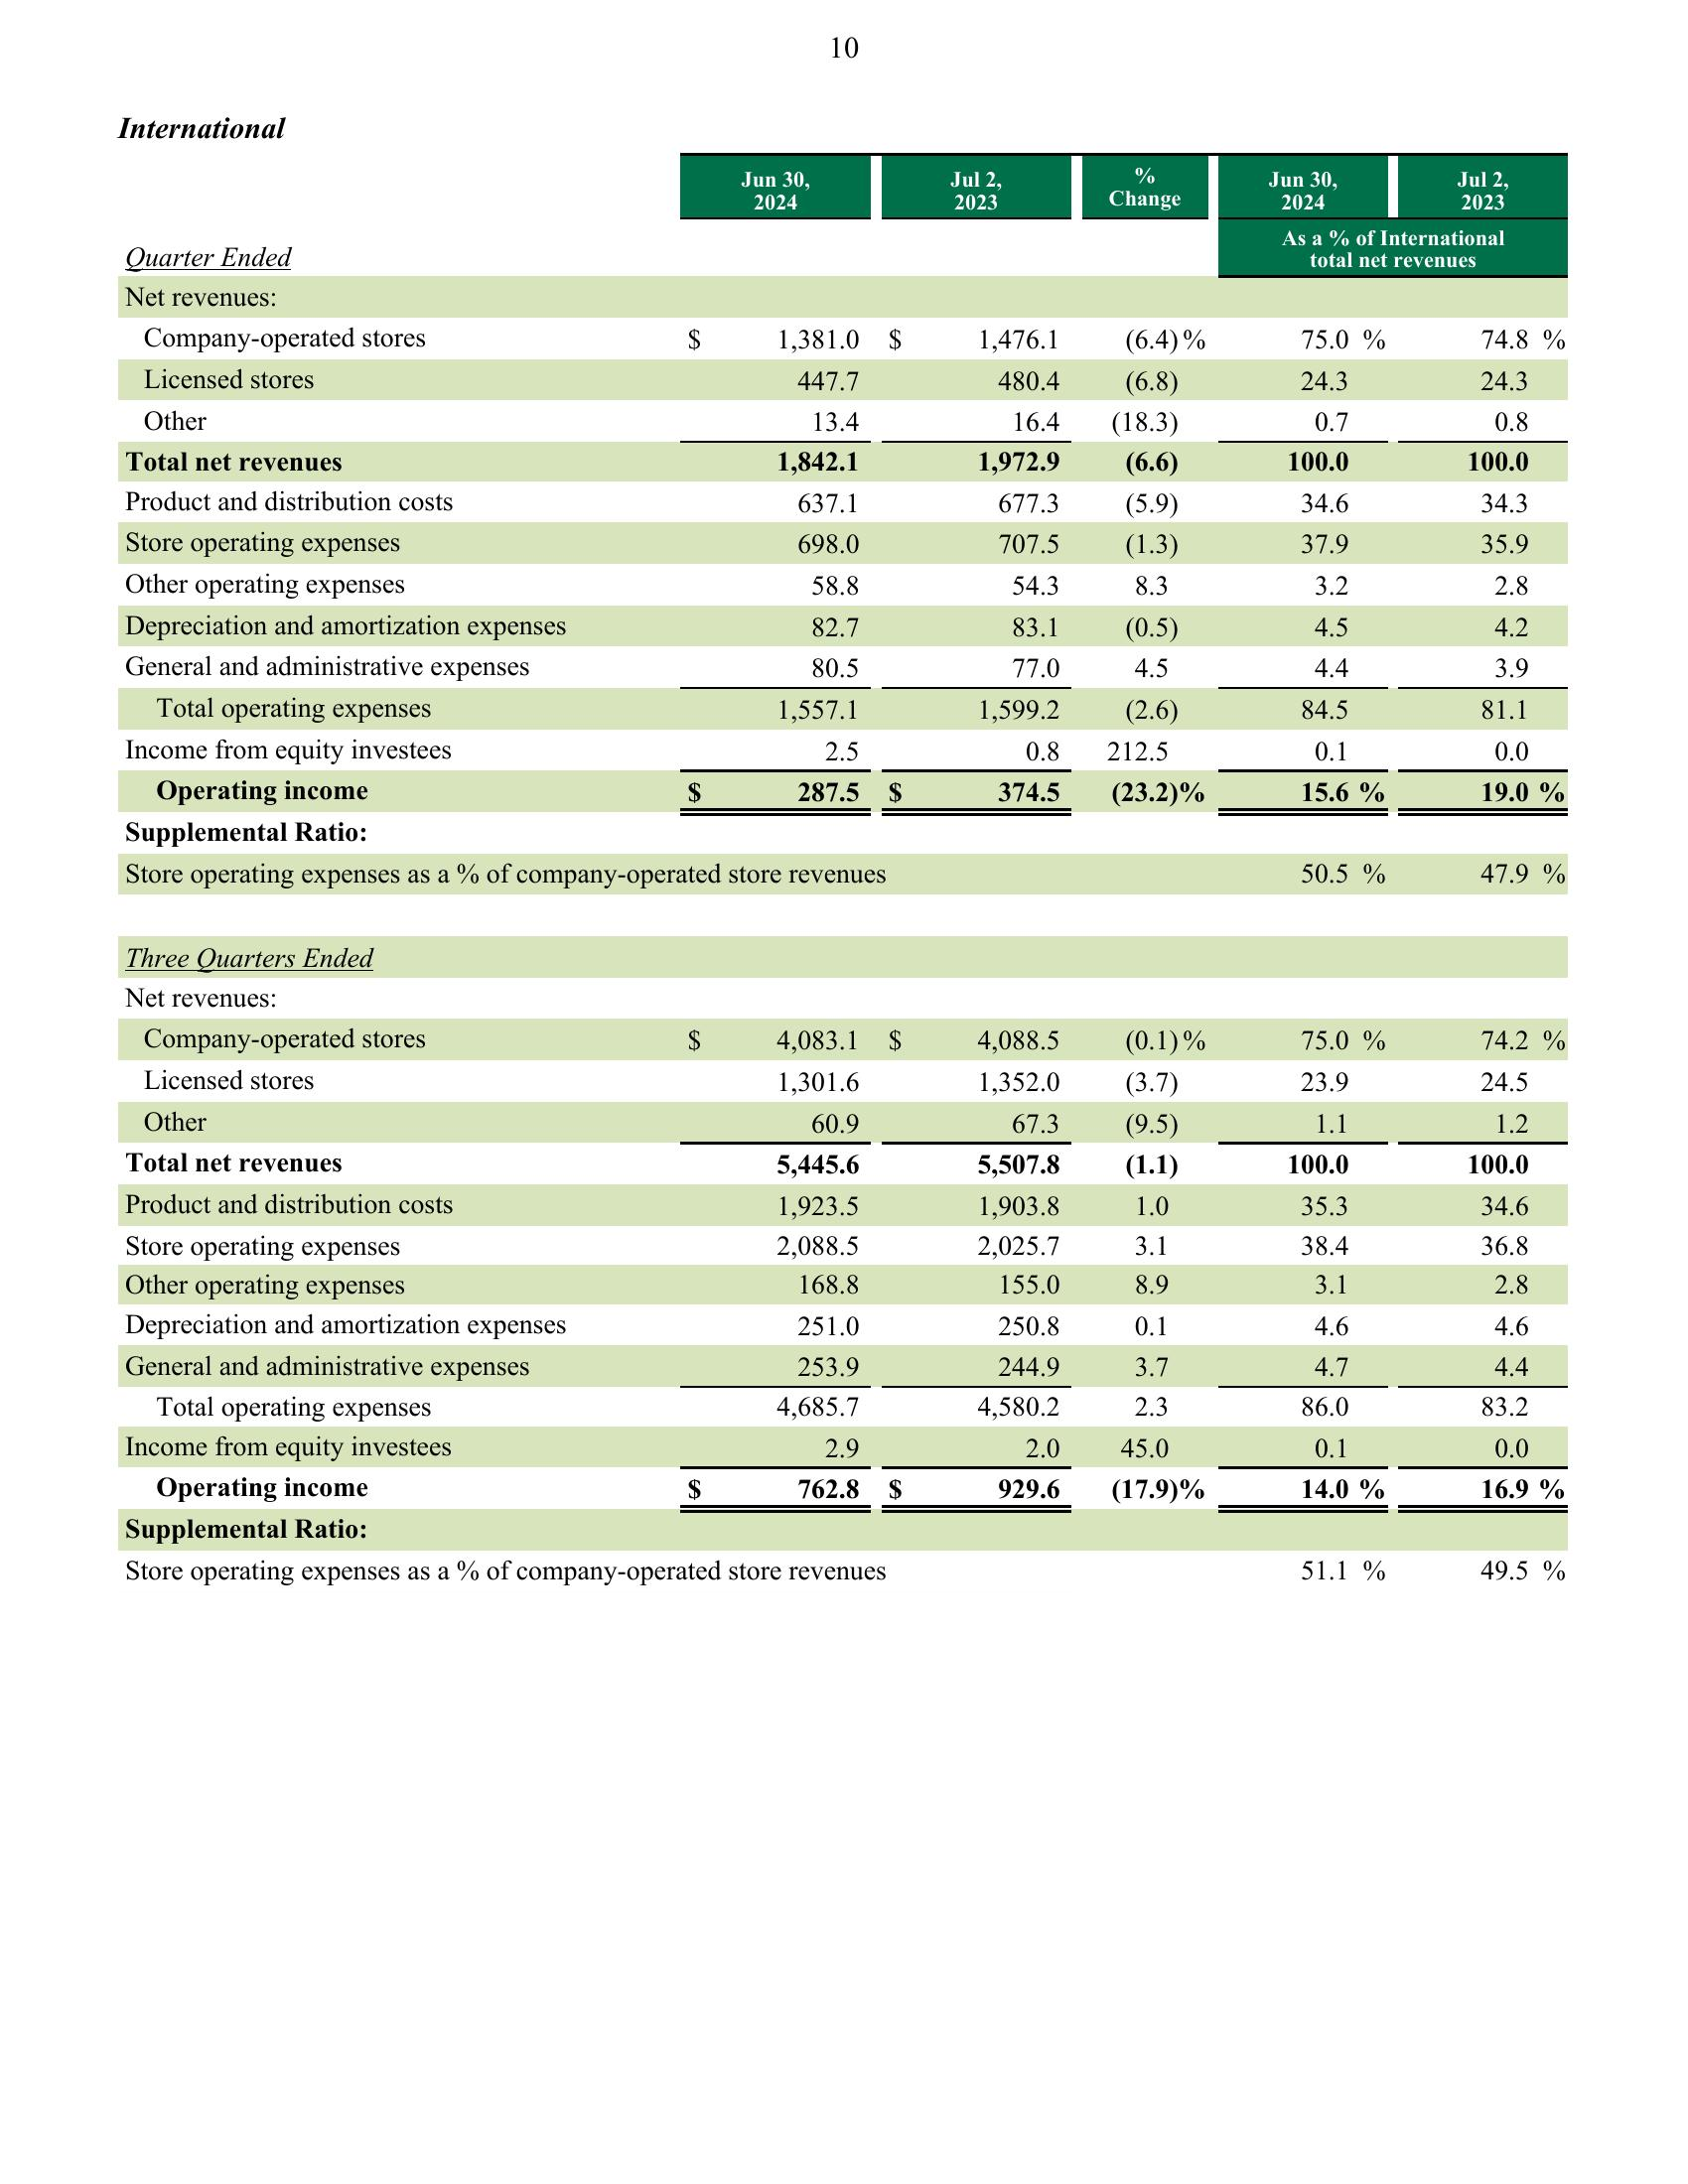

In [32]:
# PRepare the list of images
image_data_list = [{"type": "image_url",
                    "image_url": {"url": f"data:image/png;base64,{img}",
                                  "detail": "high"}} for img in base64frame]
image_data_list

In [33]:
# Prepare the message content
user_message_content = [
    {"type": "text", "text": text_context},
    *image_data_list
]

In [34]:
# Generate the answer
response = client.chat.completions.create(
    model = "gpt-4o-mini",
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_message_content}],
    temperature = 0.2)

In [35]:
# Display the generated answer
display(Markdown(response.choices[0].message.content))

Based on the provided information regarding Starbucks Corporation, here are some short-term risks the company may face:

1. **International Market Weakness**: Starbucks is experiencing challenges in several international markets, particularly in China, where comparable store sales have declined significantly (14%). This reflects intense competition and a cautious consumer environment, which could impact revenue growth.

2. **Consumer Spending Caution**: There is a noted trend of cautious consumer spending, particularly in Europe and parts of Southeast Asia. This could lead to reduced sales and profitability as consumers may prioritize essential purchases over discretionary spending like coffee.

3. **Increased Competition**: The company faces intensified competition in various markets, which could pressure pricing and margins. The mass segment price war mentioned could further erode profitability.

4. **Operational Disruptions**: Unprecedented store expansion and operational challenges in markets like Japan and Latin America have caused disruptions. If these issues persist, they could negatively impact operational efficiency and profitability.

5. **Rising Costs**: The increase in operational costs, particularly related to partner wages and benefits, may continue to pressure margins. The company has already seen a contraction in operating margin, which could further affect profitability if costs continue to rise without corresponding revenue increases.

6. **Dependence on U.S. Market**: While the U.S. business shows strength, over-reliance on this market could be risky if economic conditions change or if competition intensifies domestically.

7. **Currency Fluctuations**: As a global company, Starbucks is exposed to currency exchange risks, which can impact revenues and profits when converting foreign sales back to U.S. dollars.

8. **Supply Chain Issues**: Any disruptions in the supply chain, whether due to geopolitical tensions, natural disasters, or other factors, could affect inventory levels and operational capabilities.

These risks highlight the need for Starbucks to navigate a complex and challenging operating environment, particularly in international markets.